In [1]:
#default_exp charge

# Battery Charging

<br>

## Battery charging: problem definition

The goal of the battery charging component is to maximise the amount of charge that is drawn from solar PV, as opposed to the grid. We want to maximise: 

$$p_{d,1} = \frac{\sum{P_{d,k}}}{\sum{B_{d,k}}}$$

summing over all $k$ periods during which we can charge. We are allowed to charge during $k=1,...31$ or between 00:00 and 15:30 (that is the settlement period ending at 15:30).

##### Constraints

As with the battery discharge, the battery has a number of constraints. The first constraint is on the maximum import and export of energy, in this case:

$$-2.5MW = B_{min} \leq B_{d, k} \leq B_{max} = 2.5MW$$

Secondly the battery cannot charge beyond its capacity, $C_{d, k}$, (in MWh):

$$0 \leq C_{d, k} \leq C_{max} = 6MWh$$

The total charge in the battery at the next time step $C_{d, k+1}$ is related to how much is currently in the battery and how much charged within the battery at time $k$, i.e.

$$C_{d, k+1} = C_{d, k} + 0.5B_{d, k}$$

Finally, the battery must start empty at the start of each day in the test week. I.e. $C_{d,1} = 0$ for $d = 1, … , 7$.

##### Output

The output should be roughly the same as the battery discharge, except with positive values to indicate charging. E.g.

```
charging_profile = [
0, ## 00:00--00:30
0, ## 00:30--01:00
...
1.2, ## 14:30--15:00
0.7] ## 15:00--15:30

```

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from moepy.lowess import quantile_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from batopt import clean
from batopt import discharge

import FEAutils as hlp

In [3]:
# Should do some investigation of how the panel temp influences performance

<br>

### User Stories

In [4]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'
charge_opt_model_fp = '../models/charge_opt.sav'

<br>

### Loading Data

In [5]:
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)

df.head()

,demand,pv,weather,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
2015-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.75,9.650,8.830,7.580,11.620,11.22
2015-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.83,9.705,8.865,7.600,11.635,11.27
2015-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.91,9.760,8.900,7.620,11.650,11.32
2015-01-01 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.95,9.780,9.000,7.615,11.650,11.31
2015-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.99,9.800,9.100,7.610,11.650,11.30


<AxesSubplot:>

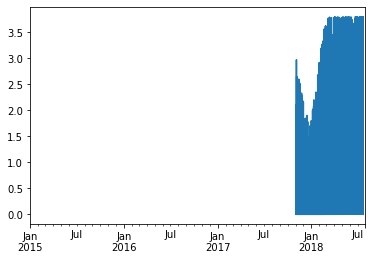

In [6]:
df.pv_power_mw.plot()

<br>

Correlations between the solar variables:

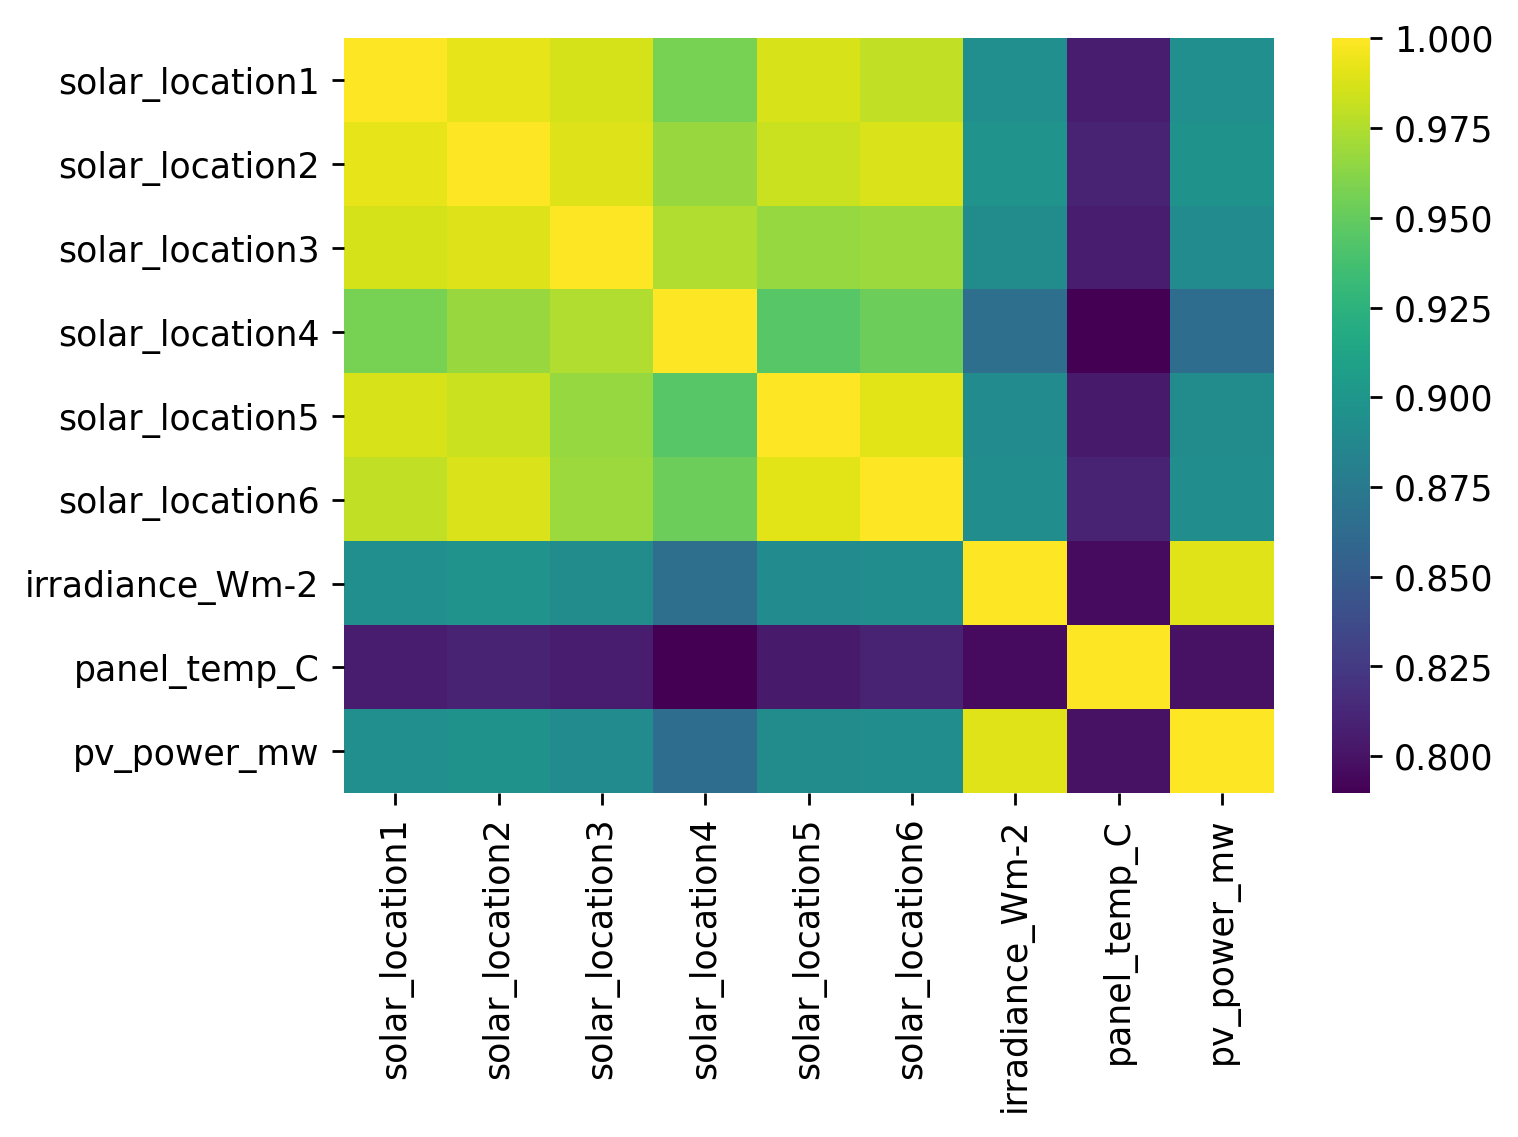

In [7]:
solar_cols = [c for c in df.columns if 'solar_location' in c]
solar_cols.append('irradiance_Wm-2')
solar_cols.append('panel_temp_C')
solar_cols.append('pv_power_mw')

fig, ax = plt.subplots(dpi=250)
df_solar = df.filter(solar_cols).copy()
ax = sns.heatmap(df_solar.corr(), cmap='viridis')
fig.savefig('../img/solar_corrplot.png')

<br>

As in the demand data, estimating the quantiles for the solar PV output:

In [8]:
#exports
def estimate_daily_solar_quantiles(x, y, x_pred = np.linspace(0, 23.5, 100), **model_kwargs):
    # Fitting the model
    df_quantiles = quantile_model(x, y, x_pred=x_pred, **model_kwargs)

    # Cleaning names and sorting for plotting
    df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
    df_quantiles = df_quantiles[df_quantiles.columns[::-1]]
    
    return df_quantiles

In [9]:
dts = df.index.tz_convert('Europe/London')
x = np.array(dts.hour + dts.minute/60)
y = df['pv_power_mw'].values

rerun_daily_solar_model = False
daily_solar_filename = 'daily_solar_quantile_model_results.csv'

if (rerun_daily_solar_model == True) or (daily_solar_filename not in os.listdir(cache_data_dir)):
    df_quantiles = estimate_daily_solar_quantiles(x, y, frac=0.2, num_fits=48, robust_iters=3)
    df_quantiles.to_csv(f'{cache_data_dir}/{daily_solar_filename}')
else:
    df_quantiles = pd.read_csv(f'{cache_data_dir}/{daily_solar_filename}', index_col='x')

<br>

And plotting

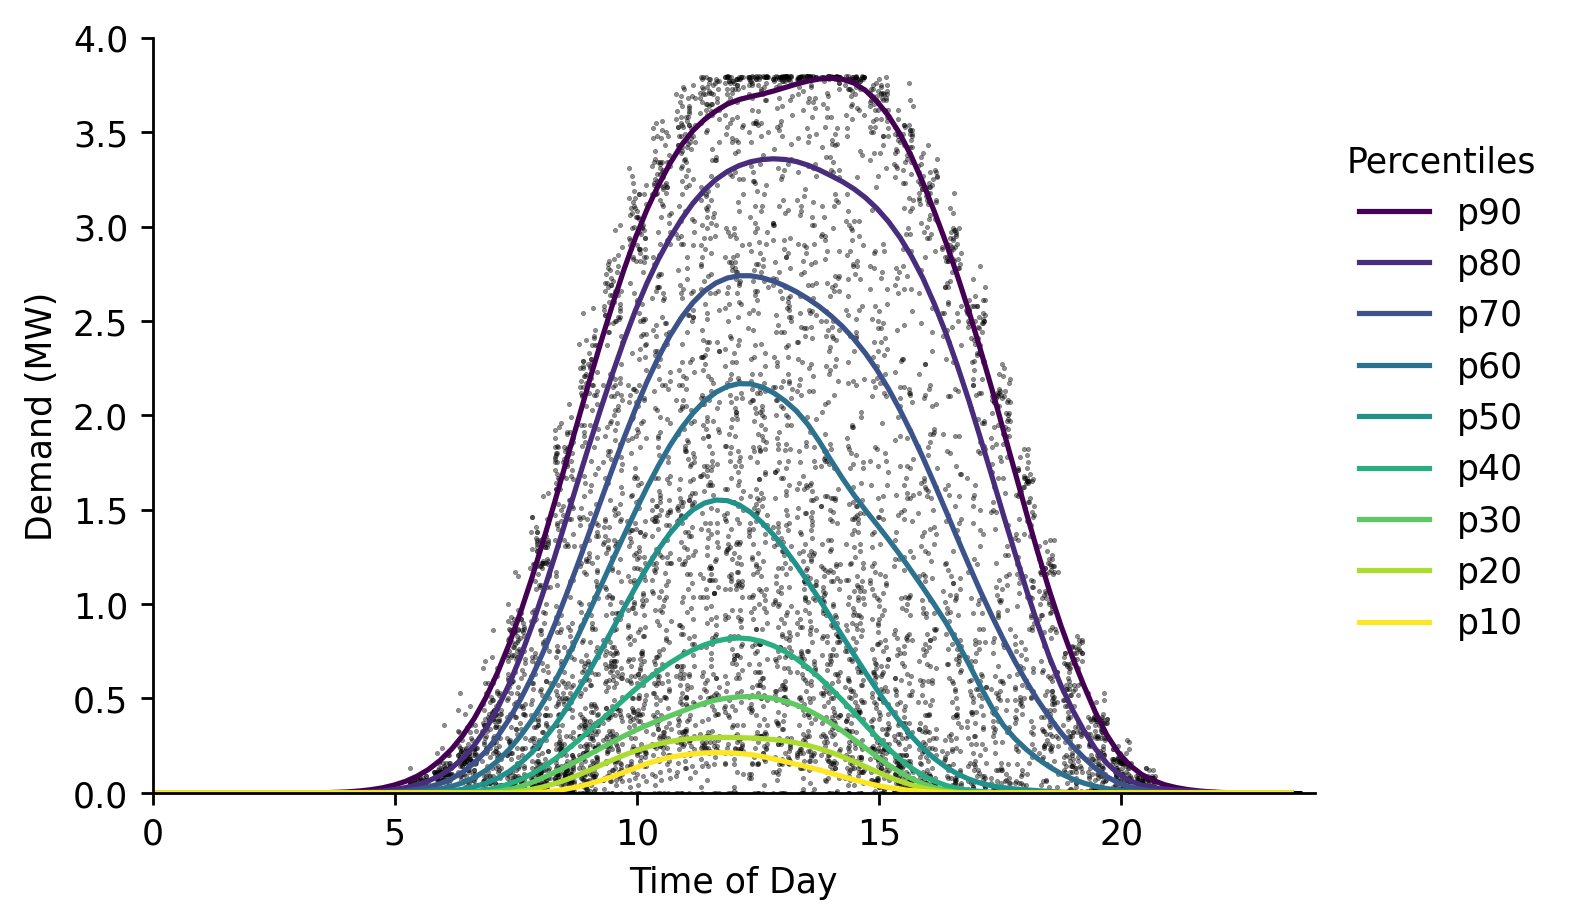

In [10]:
x_jittered = x + (np.random.uniform(size=len(x)) - 0.5)/2.5

# Plotting
fig, ax = plt.subplots(dpi=250)

ax.scatter(x_jittered, y, s=0.2, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.9), title='Percentiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Demand (MW)')
ax.set_xlim(0, 24)
ax.set_ylim(0, 4)

fig.savefig('../img/daily_solar_profile.png')

<br>

### Proportion of days during which we can fully charge the battery

It may be useful to know the proportion of days during which the battery can be fully charged. 

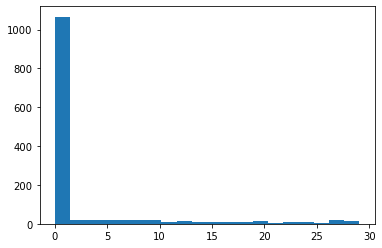

Proportion of days where solar generation exceeds 6 MWh: 13.86%


In [11]:
df_solar_hrs = df.between_time('00:00:00', '15:00:00')
pv_generation = df_solar_hrs.groupby(df_solar_hrs.index.date).sum()['pv_power_mw']*0.5 # available daily energy from PV

fig, ax = plt.subplots()
ax.hist(pv_generation, bins=20)
plt.show()

prop = np.sum(pv_generation >= 6)/pv_generation.size
print("Proportion of days where solar generation exceeds 6 MWh: {:.2f}%".format(prop*100))

<br>

### Optimal charging with perfect foresight

We will now develop an algorithm to determine the optimal charging schedule given a perfect solar forecast. 

The scoring function for the generation component rewards us taking as much energy as possible from solar PV. The proportion of energy from PV for a day $d$ is given by $$p_{d,1} = \frac{\sum{P_{d,k}}}{\sum{B_{d,k}}}$$ where we are summing over all periods $k$. An equivalent equation is applies for $p_{d,2}$ which is the energy that is drawn from the grid. The scoring function rewards $p_{d,1}$ over $p_{d,2}$ in a ratio of 3 to 1. 

Any schedule which fully exploits the solar PV potential until the battery is charged is equally good in terms of the scoring function. However, it may be worth considering methods which give a smoother charge profile for the purposes of producing a robust model for unseen days.

In addition, we need to have a method of intelligently allocating charge when the solar PV potential is less than the capacity of the battery.

Some possible methods for this:

- Naively reallocate over the middle of they day (say 09:00--15:00)
- Add charge to periods where charge has already been committed.
- Use a forecast for PV output and allocate charge proportionally to the forecast.

<AxesSubplot:>

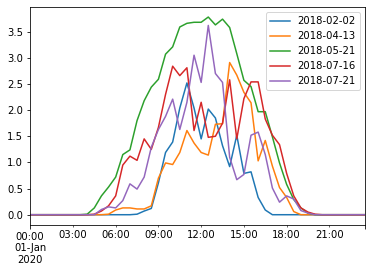

In [12]:
s_pv = df['pv_power_mw'].dropna()
solar_profile = discharge.sample_random_days(s_pv)

solar_profile.plot()

<br>

For perfect foresight, any schedule that draws all of the available solar power or 6 MWh (if the total solar production exceeds 6 MWh) is equally good. 

This first approach will aim to draw greedily from  until 6 MWh is satisfied, or all of the solar production has been expended.

In cases where there is not enough solar PV to fill the battery, we will then uniformly add the remaining capacity across all periods.

**Note: this seems to work on this dataset but won't if there is a very large spike in solar PV, such topping up uniformly causes a constraint to be violated. It also may not work if the number of periods over which we top up is decreased.**

In [13]:
#exports
def extract_solar_profile(s_solar_sample_dt, start_time='00:00', end_time='15:00'):
    dt = str(s_solar_sample_dt.index[0].date())
    solar_profile = s_solar_sample_dt[f'{dt} {start_time}':f'{dt} {end_time}'].values

    return solar_profile

def charge_profile_greedy(solar_profile, capacity=6, initial_charge=0, max_charge_rate=2.5, time_unit=0.5):
    order = np.flip(np.argsort(solar_profile))
    charge = initial_charge
    solution = np.zeros(len(solar_profile))
    for i in order:
        solar_available = np.minimum(solar_profile[i], max_charge_rate)
        solar_available = min(solar_available, (capacity - charge)/time_unit) 
        solution[i] = solar_available
        charge = np.sum(solution)*time_unit
        if charge > capacity:
            break
    return solution

def topup_charge_naive(charge_profile, capacity=6, time_unit=0.5, period_start=16, period_end=30):
    charge = np.sum(charge_profile)*time_unit
    spare_cap = capacity - charge
    topup_value = spare_cap/((period_end-period_start)*time_unit)
    new_profile = np.copy(charge_profile)
    new_profile[period_start:period_end] += topup_value # Add topup_value uniformly between start and end periods
    return new_profile

def optimal_charge_profile(solar_profile, capacity=6, time_unit=0.5, max_charge_rate=2.5):
    solution = charge_profile_greedy(solar_profile)
    solution = topup_charge_naive(solution)
    assert np.isclose(np.sum(solution), capacity/time_unit), "Does not meet capacity constraint".format(np.sum(solution)) 
    assert np.all(solution <= max_charge_rate), "Does not meet max charge rate constraint. Max is {}".format(np.max(solution))
    return solution

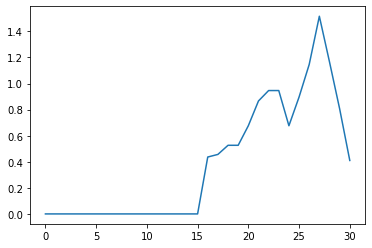

In [14]:
random_solar_profile = discharge.sample_random_day(s_pv).pipe(extract_solar_profile)
x = optimal_charge_profile(random_solar_profile) # Note there is sometimes a rounding error here

plt.plot(x)

<br>

The danger with this method is that it can be quite spiky. I wonder if this (a) makes the function difficult to learn (b) is too risky as compared with hedging bets with a more smoother approach. 

<br>

##### Smooth Approach

We can use the same peak flattening algorithm developed for the dischrge optimisation

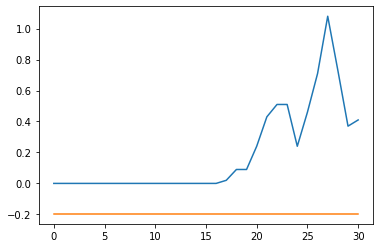

In [15]:
adj_random_solar_profile = discharge.flatten_peak(random_solar_profile)

plt.plot(random_solar_profile)
plt.plot(adj_random_solar_profile)

<br>

Which we can deduct from the original evening profile to construct the charge profile

In [16]:
#exports
construct_charge_profile = lambda solar_profile, adj_solar_profile: solar_profile - adj_solar_profile

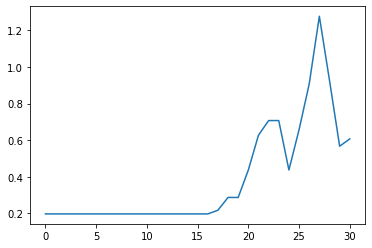

In [17]:
charge_profile = construct_charge_profile(random_solar_profile, adj_random_solar_profile)

plt.plot(charge_profile)

<br>

Rather than the sample day we've just used we'll now repeat this step for all days we have pv data on, returning a series of the new charge values that can be easily added to the discharge values

In [18]:
#exports
def construct_charge_s(s_pv, start_time='00:00', end_time='15:00'):
    s_charge = pd.Series(index=s_pv.index, dtype=float).fillna(0)

    for dt in s_pv.index.strftime('%Y-%m-%d').unique():
        solar_profile = s_pv[dt].pipe(extract_solar_profile)
        adj_solar_profile = discharge.flatten_peak(solar_profile)
        
        charge_profile = construct_charge_profile(solar_profile, adj_solar_profile)
        
        s_charge[f'{dt} {start_time}':f'{dt} {end_time}'] = charge_profile

    return s_charge

def charge_is_valid(charge_profile, capacity=6, max_charge_rate=2.5, time_unit=0.5):
    """
    Function determining if a charge profile is valid (and fully charges the battery)
    """
    if np.all(np.isclose(capacity/time_unit, charge_profile.groupby(charge_profile.index.date).sum())) is False:
        return False
    elif np.all(charge_profile.groupby(charge_profile.index.date).max() <= max_charge_rate) is False:
        return False
    else:
        return True


True

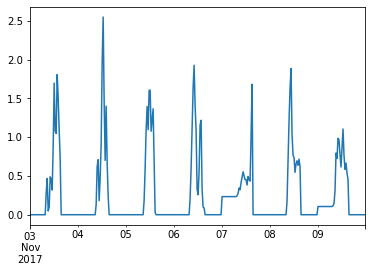

In [19]:
s_charge = construct_charge_s(s_pv, start_time='00:00', end_time='15:00')

s_charge.iloc[:48*7].plot()

charge_is_valid(s_charge)

<br>

With the greedy algorithm we can analyse the periods during which charging occurs:

<AxesSubplot:xlabel='time'>

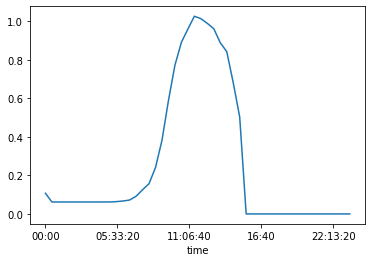

In [20]:
s_charge.groupby(s_charge.index.time).mean().plot()

<br>

Unsurprisingly we never charge before 5am. We can therefore truncate our training to just look at 05:00--15:30. 

Confirm that the optimal charge adds up to 6 MWh each day: 

In [21]:
s_charge.groupby(s_charge.index.date).sum().value_counts()

12.000000    53
12.000000    37
12.000000    34
12.000000    29
12.000000    23
12.000000    17
12.000000    10
12.000000    10
12.000000     8
12.000000     6
12.000000     5
12.000000     4
12.000000     4
12.000000     4
12.000000     3
12.000000     3
12.000000     2
12.000000     2
12.003333     1
12.000000     1
12.000000     1
12.555455     1
12.000000     1
12.160000     1
12.000000     1
12.000000     1
12.000000     1
dtype: int64

<br>

### Model development: charging

Following the same structure as battery discharge, we will aim to predict the optimal charge schedule. 

In [22]:
#exports 
def construct_df_charge_features(df, dt_rng=None):
    if dt_rng is None:
        dt_rng = pd.date_range(df.index.min(), df.index.max(), freq='30T')
        
    df_features = pd.DataFrame(index=dt_rng)
    
    # Filtering for the temperature weather data
    temp_loc_cols = df.columns[df.columns.str.contains('temp_location')]
    df_features.loc[df.index, temp_loc_cols] = df[temp_loc_cols].copy()
    df_features = df_features.ffill(limit=1)
    
    # Adding lagged demand
    df_features['demand_7d_lag'] = df['demand_MW'].shift(48*7)

    # Adding datetime features
    dts = df_features.index.tz_convert('Europe/London') # We want to use the 'behavioural' timezone

    df_features['weekend'] = dts.dayofweek.isin([5, 6]).astype(int)
    df_features['hour'] = dts.hour + dts.minute/60
    df_features['doy'] = dts.dayofyear
    df_features['dow'] = dts.dayofweek
    
    # Removing NaN values
    df_features = df_features.dropna()
    
    return df_features

#exports
def extract_charging_datetimes(df, start_hour=0, end_hour=15):
    hour = df.index.hour + df.index.minute/60
    charging_datetimes = df.index[(hour>=start_hour) & (hour<=end_hour)]
    
    return charging_datetimes

In [23]:
#exports
def prepare_training_input_data(intermediate_data_dir):
    # Loading input data
    df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)
    df_features = construct_df_charge_features(df)
    
    # Filtering for overlapping feature and target data
    dt_idx = pd.date_range(df_features.index.min(), df['demand_MW'].dropna().index.max()-pd.Timedelta(minutes=30), freq='30T')

    s_pv = df.loc[dt_idx, 'pv_power_mw']
    df_features = df_features.loc[dt_idx]
    
    # Constructing the discharge series
    s_charge = construct_charge_s(s_pv, start_time='00:00', end_time='15:00')
    
    # Filtering for evening datetimes
    charging_datetimes = extract_charging_datetimes(df_features)
    
    X = df_features.loc[charging_datetimes]
    y = s_charge.loc[charging_datetimes]
    
    return X, y, charging_datetimes

In [24]:
X, y, charging_datetimes = prepare_training_input_data(intermediate_data_dir)

X.shape, y.shape, charging_datetimes.shape

((7905, 11), (7905,), (7905,))

In [25]:
df_pred = clean.generate_kfold_preds(X.values, y.values, LinearRegression(), index=charging_datetimes)

df_pred.head()

,pred,true
2017-11-10 00:00:00+00:00,-0.172741,0.0
2017-11-10 00:30:00+00:00,-0.127696,0.0
2017-11-10 01:00:00+00:00,-0.075452,0.0
2017-11-10 01:30:00+00:00,-0.041010,0.0
2017-11-10 02:00:00+00:00,-0.001499,0.0


<br>

We need to fix the predictions such that they satisfy the battery constraints. We will do this in the same way as applied in the battery discharge component, first clipping the charge rate to be between 0--2.5MW, then normalising such that the total charge sums to 6 MWh.

In [26]:
#exports
def normalise_total_charge(s_pred, charge=6., time_unit=0.5):
    s_daily_charge = s_pred.groupby(s_pred.index.date).sum()

    for date, total_charge in s_daily_charge.items():
        
        with np.errstate(invalid='ignore'):
            s_pred.loc[str(date)] *= (charge/(time_unit*total_charge))
        
    return s_pred    

clip_charge_rate = lambda s_pred, max_rate=2.5, min_rate=0: s_pred.clip(lower=max_rate, upper=min_rate)

post_pred_charge_proc_func = lambda s_pred: (s_pred
                                      .pipe(clip_charge_rate)
                                      .pipe(normalise_total_charge)
                                     )


In [27]:
post_pred_charge_proc_func(df_pred['true']).groupby(df_pred.index.date).sum().value_counts()

12.0    131
12.0     48
12.0     41
12.0     16
12.0     15
12.0      2
12.0      1
12.0      1
Name: true, dtype: int64

<br>

### Model Comparison Metrics

Schedules are scored according to the proportion of the total battery charge that comes from solar: $p_{d,1} = \frac{\sum{P_{d,k}}}{\sum{B_{d,k}}}$.

We will first write a function which evaluates this scoring function for a charging schedule and solar profile. 

In [28]:
def score_charging(schedule, solar_profile):
    # The actual pv charge is the minimum of the scheduled charge and the actual solar availability 
    actual_pv_charge = np.minimum(schedule, solar_profile) 
    score = np.sum(actual_pv_charge)/np.sum(schedule)
    return score

# example: 
df_pred['pred'] = post_pred_charge_proc_func(df_pred['pred'])
schedule = discharge.sample_random_day(df_pred['pred'])
solar_profile = df.loc[schedule.index]['pv_power_mw']

print("Score for random day: {}".format(score_charging(schedule, solar_profile)))

# example: 
schedule = df_pred['pred']
solar_profile = df.loc[schedule.index]['pv_power_mw']
print("Score for entire dataset: {}".format(score_charging(schedule, solar_profile)))

Score for random day: 0.564142662076004
Score for entire dataset: 0.723833631943722


<br>

**However** remember that some days there is not enough solar PV to fill the battery. It would be good to know what % of the max score we achieved. That is, the sum of our PV charge over the total available PV capacity (capped at 6 MWh per day). 

In [29]:
def max_available_solar(solar_profile, capacity_mwh=6, time_unit=0.5):
    """
    Return the solar PV potential available to the battery.
    
    That is, the total PV potential with a daily cap of 6 MWh. 
    """
    available = solar_profile.groupby(solar_profile.index.date).sum() * time_unit
    clipped = np.clip(available.values, 0, capacity_mwh)
    total = np.sum(clipped)
    return total 

max_available_solar(df.loc[schedule.index]['pv_power_mw'])    

1283.5549999999998

<br>

Now we need a function to evaluate a schedule as a proportion of the max available score. That is, the total PV charge used by the battery divided by the total available solar PV. 

In [30]:
def prop_max_solar(schedule, solar_profile, time_unit=0.5):
    actual_pv_charge = np.sum(np.minimum(schedule, solar_profile)*time_unit)
    max_pv_charge = max_available_solar(solar_profile)
    return actual_pv_charge/max_pv_charge

# example: 
df_pred['pred'] = post_pred_charge_proc_func(df_pred['pred'])
schedule = discharge.sample_random_day(df_pred['pred'])
solar_profile = df.loc[schedule.index]['pv_power_mw']
print("Score for random day: {}".format(prop_max_solar(schedule, solar_profile)))

# example: 
schedule = df_pred['pred']
solar_profile = df.loc[schedule.index]['pv_power_mw']
print("Score for entire dataset: {}".format(prop_max_solar(schedule, solar_profile)))

Score for random day: 1.0
Score for entire dataset: 0.8628110652631892


<br>

### Model comparison

Now let's try some different models and view their scores and the proportion of maximum PV potential:

In [31]:
models = {
    'std_linear': LinearRegression(),
    'boosted': GradientBoostingRegressor(),
    'random_forest': RandomForestRegressor(),
}

for key in models:
    df_pred = clean.generate_kfold_preds(X.values, y.values, models[key], index=charging_datetimes)
    df_pred['pred'] = post_pred_charge_proc_func(df_pred['pred'])
    schedule = df_pred['pred']
    solar_profile = df.loc[schedule.index]['pv_power_mw']
    score = score_charging(schedule, solar_profile)
    prop_max = prop_max_solar(schedule, solar_profile)
    print(f"Model: `{key}`    Score: {score:.3f}     Proportion of max: {100*prop_max:.3f}%")

Model: `std_linear`    Score: 0.724     Proportion of max: 86.276%
Model: `boosted`    Score: 0.769     Proportion of max: 91.646%
Model: `random_forest`    Score: 0.801     Proportion of max: 95.477%


Final check that the predictions meet the constraints:

In [32]:
print(df_pred['pred'].groupby(df_pred.index.date).sum().value_counts()) # Should sum to 12 MWh for all days
print(np.max(df_pred['pred'])) # Max should not exceed 2.5 MW

12.0    87
12.0    56
12.0    55
12.0    31
12.0    19
12.0     4
12.0     3
Name: pred, dtype: int64
1.7450109682229409


Checking out the average day:

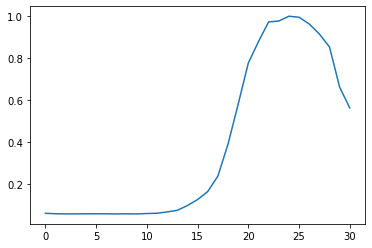

In [33]:
average_day = df_pred.pred.astype('float').groupby(df_pred.index.time).mean().values
plt.plot(average_day)

In [34]:
#exports
def fit_and_save_charging_model(X, y, charge_opt_model_fp, model_class=RandomForestRegressor, **model_params):
    model = model_class(**model_params)
    model.fit(X, y)
    
    with open(charge_opt_model_fp, 'wb') as fp:
        joblib.dump(model, fp)
        
    return

In [35]:
X, y, charging_datetimes = prepare_training_input_data(intermediate_data_dir)
fit_and_save_charging_model(X, y, charge_opt_model_fp)

### Test evaluation

In [36]:
df_features = discharge.prepare_latest_test_feature_data(raw_data_dir, intermediate_data_dir)

In [37]:
#exports
def load_trained_model(charge_opt_model_fp):
    with open(charge_opt_model_fp, 'rb') as fp:
        model = joblib.load(fp)
    
    return model

In [38]:
#exports
def optimise_latest_test_charge_profile(raw_data_dir, intermediate_data_dir, charge_opt_model_fp, latest_submission_template_name=None):
    df_features = discharge.prepare_latest_test_feature_data(raw_data_dir, intermediate_data_dir, latest_submission_template_name=latest_submission_template_name)
    charging_datetimes = extract_charging_datetimes(df_features)
    X_test = df_features.loc[charging_datetimes].values
    model = load_trained_model(charge_opt_model_fp)
    charge_profile = model.predict(X_test)    
    charge_profile = pd.Series(charge_profile, index=charging_datetimes)
    charge_profile = charge_profile.reindex(df_features.index).fillna(0)
    charge_profile = post_pred_charge_proc_func(charge_profile)
    
    assert charge_is_valid(charge_profile), "Charging profile is invalid"
    
    return charge_profile


Charge is valid: True


<AxesSubplot:xlabel='datetime'>

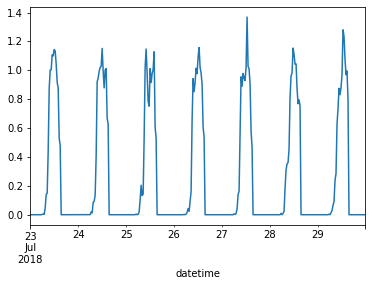

In [39]:

charge_profile = optimise_latest_test_charge_profile(raw_data_dir, intermediate_data_dir, charge_opt_model_fp)
print("Charge is valid: {}".format(charge_is_valid(charge_profile)))
charge_profile.plot()

<br>

Finally we'll export the relevant code to our `batopt` module

In [40]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-data-cleaning.ipynb.
Converted 02-battery-discharge.ipynb.
Converted 03-battery-charge.ipynb.
Converted 04-battery-optimisation.ipynb.
Converted 05-evaluation.ipynb.
Converted 06-pipeline.ipynb.


In [41]:
foo = charge_profile[:10]
goo = charge_profile[10:20]
pd.concat([foo, goo])

datetime
2018-07-23 00:00:00+00:00    0.000135
2018-07-23 00:30:00+00:00    0.000000
2018-07-23 01:00:00+00:00    0.000000
2018-07-23 01:30:00+00:00    0.000000
2018-07-23 02:00:00+00:00    0.000000
2018-07-23 02:30:00+00:00    0.000000
2018-07-23 03:00:00+00:00    0.000000
2018-07-23 03:30:00+00:00    0.000000
2018-07-23 04:00:00+00:00    0.000000
2018-07-23 04:30:00+00:00    0.000000
2018-07-23 05:00:00+00:00    0.000000
2018-07-23 05:30:00+00:00    0.000000
2018-07-23 06:00:00+00:00    0.001813
2018-07-23 06:30:00+00:00    0.004939
2018-07-23 07:00:00+00:00    0.002734
2018-07-23 07:30:00+00:00    0.047278
2018-07-23 08:00:00+00:00    0.139684
2018-07-23 08:30:00+00:00    0.148454
2018-07-23 09:00:00+00:00    0.441971
2018-07-23 09:30:00+00:00    0.872841
dtype: float64